In [1]:
# Imports for data prep, modeling, and plotting in one place
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from scipy import stats

Collect and preprocessing the data

In [2]:
# Load raw GEFCOM file (space-separated, custom column names)
gefcom = pd.read_csv(
    'Data/GEFCOM.txt',
    sep=r"\s+",
    names=['Date', 'Hour', 'Price', 'System_load', 'Zonal_load', 'Day_of_week'],
)

In [3]:
# Quick dtype check (dates come in as ints)
gefcom.dtypes

Date           float64
Hour           float64
Price          float64
System_load    float64
Zonal_load     float64
Day_of_week    float64
dtype: object

In [4]:
# Parse YYYYMMDD integers into real dates
gefcom['Date'] = pd.to_datetime(gefcom['Date'], format='%Y%m%d')

In [5]:
# Basic descriptive stats for a first look
gefcom.describe()

,Date,Hour,Price,System_load,Zonal_load,Day_of_week
count,25968,25968.00000,25968.000000,25968.000000,25968.000000,25968.000000
mean,2012-06-24 12:00:00,11.50000,48.190072,18165.881200,6105.779767,4.000000
min,2011-01-01 00:00:00,0.00000,12.520000,11544.000000,3395.000000,1.000000
25%,2011-09-28 00:00:00,5.75000,33.470000,15620.000000,5131.000000,2.000000
50%,2012-06-24 12:00:00,11.50000,42.870000,18069.000000,6076.000000,4.000000
75%,2013-03-22 00:00:00,17.25000,54.300000,19858.250000,6714.000000,6.000000
max,2013-12-17 00:00:00,23.00000,363.800000,33449.000000,11441.000000,7.000000
std,NaN,6.92232,26.179381,3453.664269,1309.476852,2.002348


In [6]:
# Missing counts per column (rows with NaN will be dropped)
gefcom.isna().sum()

Date           0
Hour           0
Price          0
System_load    0
Zonal_load     0
Day_of_week    0
dtype: int64

In [7]:
# Check for duplicate rows
gefcom.duplicated().sum()

np.int64(0)

In [8]:
# Log-transform price to stabilize variance before lags
gefcom['Log_price'] = np.log(gefcom['Price'])

# Model building

$p_{d,h} = \beta_{0} + \beta_{1p_{d-1,h}} + \beta_{2p_{d-2,h}} + \beta_{3p_{d-7,h}} + \beta_{4p_{min,d-1}} + \beta_{5z_{d}} + \sum \beta_{D} D_{d} + \epsilon_{d,h}$

In [9]:
# Build ARX-style features: price lags, daily min, log load, weekday dummies
gefcom["p_lag1"] = gefcom["Log_price"].shift(24)
gefcom["p_lag2"] = gefcom["Log_price"].shift(48)
gefcom["p_lag7"] = gefcom["Log_price"].shift(168)

daily_min = gefcom.groupby("Date")["Log_price"].min().shift(1)
gefcom = gefcom.merge(daily_min.rename("min_price"), on="Date")

gefcom["Log_system_load"] = np.log(gefcom["System_load"])

gefcom["D_1"] = (gefcom["Day_of_week"] == 1).astype(int)
gefcom["D_6"] = (gefcom["Day_of_week"] == 6).astype(int)
gefcom["D_7"] = (gefcom["Day_of_week"] == 7).astype(int)

X_cols = ['p_lag1', 'p_lag2', 'p_lag7', 'min_price',
          'Log_system_load', 'D_1', 'D_6', 'D_7']

# Drop rows with missing features/target
mask_valid = ~gefcom[['Log_price'] + X_cols].isna().any(axis=1)
gefcom = gefcom[mask_valid].reset_index(drop=True)

# Simple day index for window logic
orig_start_date = gefcom["Date"].min()
gefcom["day_id"] = (gefcom["Date"] - orig_start_date).dt.days

gefcom_plot = gefcom.copy()

/var/folders/kf/fpf7cl4d74g_zpz2l3v784zr0000gn/T/ipykernel_2199/2446850071.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


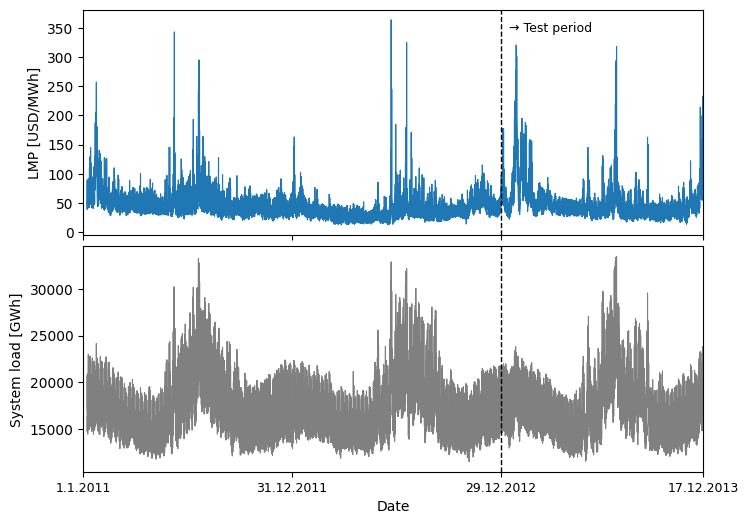

In [10]:
# Plot price/load over time and mark the train/test split date
split_date = pd.Timestamp("2012-12-29")

x_ticks = [
    pd.Timestamp("2011-01-01"),
    pd.Timestamp("2011-12-31"),
    pd.Timestamp("2012-12-29"),
    pd.Timestamp("2013-12-17")
]
x_labels = ["1.1.2011", "31.12.2011", "29.12.2012", "17.12.2013"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True,
                               gridspec_kw={'hspace': 0.05})

ax1.plot(gefcom_plot["Date"], gefcom_plot["Price"], linewidth=0.8)
ax1.set_ylabel("LMP [USD/MWh]", fontsize=10)

ax2.plot(gefcom_plot["Date"], gefcom_plot["System_load"], linewidth=0.8, color="gray")
ax2.set_ylabel("System load [GWh]", fontsize=10)
ax2.set_xlabel("Date", fontsize=10)

xmin = gefcom_plot["Date"].min()
xmax = gefcom_plot["Date"].max()
ax1.set_xlim(xmin, xmax)

ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_labels, fontsize=9)

for ax in [ax1, ax2]:
    ax.axvline(split_date, color="k", linestyle="--", linewidth=1)

ax1.text(split_date + pd.Timedelta(days=15), 350,
         "→ Test period", fontsize=9, va="center")

plt.tight_layout()
plt.show()

In [ ]:
# Train/test split and per-hour slices (separate model per hour)
train = gefcom[gefcom["Date"] < split_date].reset_index(drop=True)
test = gefcom[gefcom["Date"] >= split_date].reset_index(drop=True)

windows_length = list(range(28, 729))
hours = range(24)

hours_all   = gefcom["Hour"].values
day_ids_all = gefcom["day_id"].values
X_all       = gefcom[X_cols].to_numpy(dtype=float)
y_all       = gefcom["Log_price"].to_numpy(dtype=float)

hours_test_all   = test["Hour"].values
test_day_ids_all = test["day_id"].values
test_X_all       = test[X_cols].to_numpy(dtype=float)

y_true = test["Price"].to_numpy()

# Per-hour buckets for separate models
hour_data = {}
for h in hours:
    mask_train_h = (hours_all == h)
    mask_test_h  = (hours_test_all == h)
    hour_data[h] = {
        'X': X_all[mask_train_h],
        'y': y_all[mask_train_h],
        'day_ids': day_ids_all[mask_train_h],
        'X_test': test_X_all[mask_test_h],
        'day_ids_test': test_day_ids_all[mask_test_h],
        'test_mask_global': mask_test_h,
    }


def fit_ols(X, y):
    """Closed-form OLS fit with an intercept column prepended."""
    X_ols = np.column_stack([np.ones((X.shape[0], 1)), X])
    beta, *_ = np.linalg.lstsq(X_ols, y, rcond=None)
    return beta


def predict_ols(X, beta):
    """Apply OLS coefficients (beta) to design matrix X with an intercept."""
    X_ols = np.column_stack([np.ones((X.shape[0], 1)), X])
    return X_ols @ beta


def run_hour_for_window(T, h):
    """Fit OLS on the last T days for hour h and predict that hour in the test set."""
    data = hour_data[h]
    X_h, y_h, day_h = data['X'], data['y'], data['day_ids']
    X_test_h, test_day_h = data['X_test'], data['day_ids_test']

    preds = np.full_like(test_day_h, np.nan, dtype=float)

    # Slide over test days and refit on the latest window
    for d_day in np.unique(test_day_h):
        mask_cal = (day_h >= d_day - T) & (day_h < d_day)
        X_train = X_h[mask_cal]
        y_train = y_h[mask_cal]
        if X_train.shape[0] == 0:
            continue  # skip if no history

        beta = fit_ols(X_train, y_train)
        mask_test_day = (test_day_h == d_day)
        X_test_day = X_test_h[mask_test_day]
        preds_day = predict_ols(X_test_day, beta)
        preds[mask_test_day] = preds_day

    return h, preds


def run_window(T):
    """Generate full test predictions for all hours using window length T."""
    preds_window = np.full(len(test), np.nan, dtype=float)

    outputs = Parallel(n_jobs=-1, backend='loky')(
        delayed(run_hour_for_window)(T - 7, h) for h in hours
    )

    for h, preds_h in outputs:
        preds_window[hour_data[h]['test_mask_global']] = preds_h

    return {'T': T, 'Predictions': preds_window}

In [12]:
# Loop over window lengths, fit hourly OLS, collect MAE in price space
pred_dict_ARX = {}
pred_price_ARX = {}
mae_rows = []

for T in tqdm(windows_length, desc="Window length (ARX)"):
    r = run_window(T)
    pred_log = r["Predictions"]

    # Store log-price forecasts
    pred_dict_ARX[T] = pred_log

    # Back-transform to price space (for MAE)
    pred_price = np.exp(pred_log)
    pred_price_ARX[T] = pred_price

    # MAE in price space
    mask = ~np.isnan(pred_price) & ~np.isnan(y_true)
    mae = np.mean(np.abs(y_true[mask] - pred_price[mask]))
    mae_rows.append({"T": T, "MAE": mae})

Win_T = pd.DataFrame(mae_rows).sort_values("T").reset_index(drop=True)
print(Win_T.head())
print(Win_T.tail())

Window length (ARX): 100%|██████████| 701/701 [01:45<00:00,  6.63it/s]


    T       MAE
0  28  7.758049
1  29  7.560006
2  30  7.529535
3  31  7.565831
4  32  7.478581
       T       MAE
696  724  6.984355
697  725  6.983965
698  726  6.985569
699  727  6.986593
700  728  6.981507


In [ ]:
set_defs_arx = {
    "AW(364,728)": [364, 728],
    "AW(28,728)": [28, 728],
    "AW(56,728)": [56, 728],
    "AW(28:728)": list(range(28, 729, 1)),
    "AW(28:7:728)": list(range(28, 729, 7)),
    "AW(28:14:728)": list(range(28, 729, 14)),
    "AW(28:28:728)": list(range(28, 729, 28)),
    "AW(28:28:84,714:7:728)": list(range(28, 85, 28)) + list(range(714, 729, 7)),
    "AW(28,56,728)": [28, 56, 728],
    "AW(28,56,364,728)": [28, 56, 364, 728],
    "AW(28,56,721,728)": [28, 56, 721, 728],
}


def compute_aw_mae(pred_price_dict, Tset, name, y_true):
    """Compute MAE of an averaged-window set (price space) for a given list of windows."""
    Ts_available = [T for T in Tset if T in pred_price_dict]
    if len(Ts_available) == 0:
        return None

    preds_price_mat = np.vstack([pred_price_dict[T] for T in Ts_available])
    preds_price_avg = np.nanmean(preds_price_mat, axis=0)

    mask = ~np.isnan(preds_price_avg) & ~np.isnan(y_true)
    mae = np.mean(np.abs(y_true[mask] - preds_price_avg[mask]))

    return {
        "Name": name,
        "Size": len(Ts_available),
        "MAE": mae,
        "Tset": Ts_available,
    }


def build_aw_df(set_defs, pred_price_dict, y_true):
    """Build a dataframe of MAE results for all window-set definitions provided."""
    aw_rows = []
    for name, Tset in set_defs.items():
        row = compute_aw_mae(pred_price_dict, Tset, name, y_true)
        if row is not None:
            aw_rows.append(row)
    return pd.DataFrame(aw_rows).sort_values("MAE").reset_index(drop=True)


AW_ARX = build_aw_df(set_defs_arx, pred_price_ARX, y_true)
AW_ARX

,Name,Size,MAE,Tset
0,"AW(28,56,721,728)",4,6.479801,"[28, 56, 721, 728]"
1,"AW(28,56,364,728)",4,6.501092,"[28, 56, 364, 728]"
2,"AW(28,56,728)",3,6.508577,"[28, 56, 728]"
3,"AW(28:28:84,714:7:728)",6,6.513939,"[28, 56, 84, 714, 721, 728]"
4,"AW(28,728)",2,6.590983,"[28, 728]"
5,"AW(56,728)",2,6.637487,"[56, 728]"
6,AW(28:28:728),26,6.858084,"[28, 56, 84, 112, 140, 168, 196, 224, 252, 280..."
7,AW(28:14:728),51,6.879129,"[28, 42, 56, 70, 84, 98, 112, 126, 140, 154, 1..."
8,AW(28:7:728),101,6.891014,"[28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98, 1..."
9,AW(28:728),701,6.898324,"[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3..."


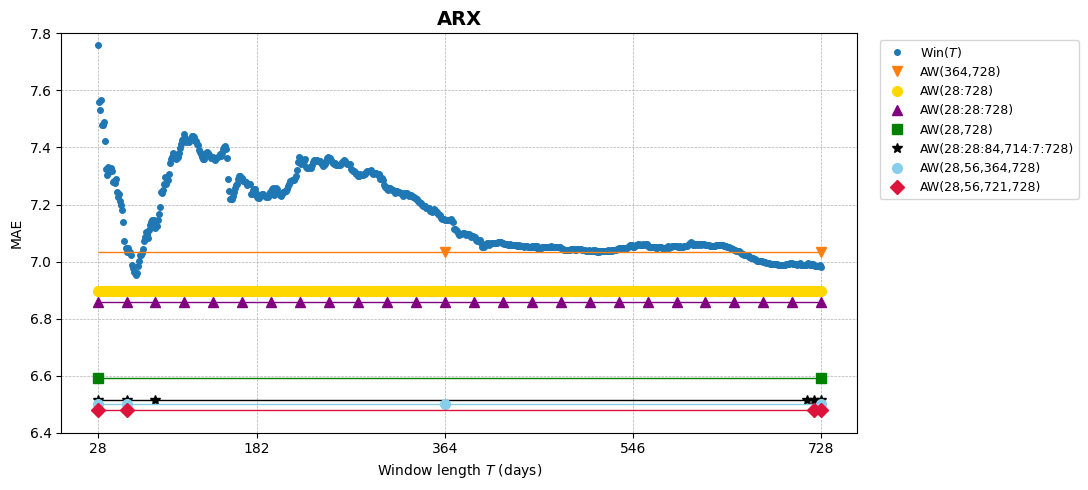

In [14]:
# Plot MAE for single windows and averaging strategies
plot_order = [
    ('AW(364,728)', 'v', 'tab:orange'),
    ('AW(28:728)', 'o', 'gold'),
    ('AW(28:28:728)', '^', 'purple'),
    ('AW(28,728)', 's', 'green'),
    ('AW(28:28:84,714:7:728)', '*', 'black'),
    ('AW(28,56,364,728)', 'o', 'skyblue'),
    ('AW(28,56,721,728)', 'D', 'crimson'),
]

fig, ax = plt.subplots(figsize=(11, 5))

# Win(T) baseline curve
ax.plot(
    Win_T['T'], Win_T['MAE'],
    'o', color='tab:blue', markersize=4,
    label=r"$\mathrm{Win}(T)$"
)

# Averaged-window sets
for (name, marker, color) in plot_order:
    row = AW_ARX[AW_ARX['Name'] == name]
    if row.empty:
        continue

    mae = row['MAE'].values[0]
    ax.hlines(mae, xmin=28, xmax=728, colors=color, linestyles='-', linewidth=1)

    x_points = np.array(set_defs_arx[name])
    y_points = np.full_like(x_points, mae, dtype=float)

    ax.plot(x_points, y_points, marker=marker, color=color,
            linestyle='None', markersize=7, label=name)

ax.set_xlabel('Window length $T$ (days)')
ax.set_ylabel('MAE')
ax.set_ylim([6.4, 7.8])
ax.set_title('ARX', fontweight='bold', fontsize=14)
ax.set_xticks([28, 182, 364, 546, 728])
ax.grid(True, linestyle='--', linewidth=0.5)

# Legend placed right to avoid clutter
ax.legend(fontsize=9, loc='upper left',
          bbox_to_anchor=(1.02, 1), frameon=True)

plt.tight_layout()
plt.show()

In [15]:
# Table: Win(T) and AW + % change vs Win(728)
table_rows = [
    "Win(28)",
    "Win(364)",
    "AW(364,728)",
    "Win(728)",
    "AW(28:728)",
    "AW(28:7:728)",
    "AW(28:14:728)",
    "AW(28:28:728)",
    "AW(56,728)",
    "AW(28,728)",
    "AW(28:28:84,714:7:728)",
    "AW(28,56,728)",
    "AW(28,56,364,728)",
    "AW(28,56,721,728)",
]

win_mae = {f"Win({int(t)})": float(m) for t, m in zip(Win_T["T"], Win_T["MAE"])}
aw_mae = {name: float(mae) for name, mae in zip(AW_ARX["Name"], AW_ARX["MAE"])}

rows = []
for name in table_rows:
    if name.startswith("Win("):
        mae = win_mae.get(name, np.nan)
    else:
        mae = aw_mae.get(name, np.nan)
    rows.append({"Windows": name, "MAE": mae})

ARX_table_paper = pd.DataFrame(rows)

baseline = float(ARX_table_paper.loc[ARX_table_paper["Windows"] == "Win(728)", "MAE"].values[0])
ARX_table_paper["%chng."] = np.log(baseline / ARX_table_paper["MAE"]) * 100

ARX_table_paper["MAE"] = ARX_table_paper["MAE"].map(lambda v: f"{v:.3f}")
ARX_table_paper["%chng."] = ARX_table_paper["%chng."].map(lambda v: f"{v:.2f}%")
ARX_table_paper.loc[ARX_table_paper["Windows"] == "Win(728)", "%chng."] = "—"

ARX_table_paper

,Windows,MAE,%chng.
0,Win(28),7.758,-10.55%
1,Win(364),7.147,-2.35%
2,"AW(364,728)",7.032,-0.72%
3,Win(728),6.982,—
4,AW(28:728),6.898,1.20%
5,AW(28:7:728),6.891,1.30%
6,AW(28:14:728),6.879,1.48%
7,AW(28:28:728),6.858,1.78%
8,"AW(56,728)",6.637,5.05%
9,"AW(28,728)",6.591,5.76%


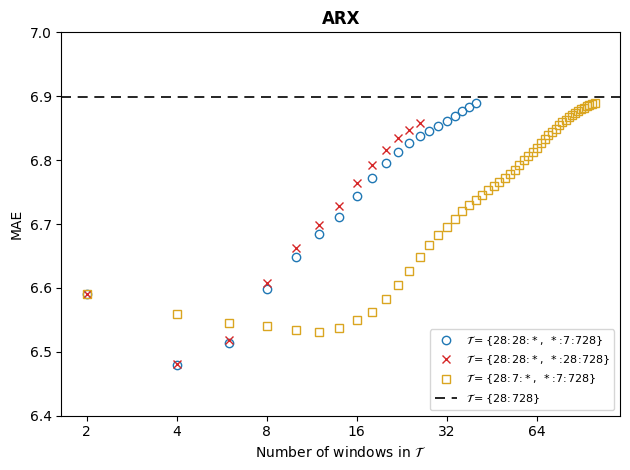

In [16]:
def mae_for_Tset(Tset):
    """MAE of equal-mean ensemble for a given list of windows (price space)."""
    preds_price_mat = np.vstack([np.exp(pred_dict_ARX[T]) for T in Tset])
    preds_price_avg = np.nanmean(preds_price_mat, axis=0)
    mask = ~np.isnan(preds_price_avg) & ~np.isnan(y_true)
    return np.mean(np.abs(y_true[mask] - preds_price_avg[mask]))


def iterative_sets(m, n, Tmin=28, Tmax=728):
    """Generate symmetric growing window sets: step outwards by m and n from Tmin/Tmax until overlap."""
    short = [Tmin]
    long = [Tmax]
    sets = [sorted(short + long)]
    while True:
        s_next = short[-1] + m
        l_next = long[-1] - n
        if s_next >= l_next:
            break
        short.append(s_next)
        long.append(l_next)
        sets.append(sorted(short + long))
    return sets


series = [
    (28, 7,  "o", "tab:blue",  r"$\mathcal{T}=\{28\!:\!28\!:\!*,\; *\!:\!7\!:\!728\}$"),
    (28, 28, "x", "tab:red",   r"$\mathcal{T}=\{28\!:\!28\!:\!*,\; *\!:\!28\!:\!728\}$"),
    (7,  7,  "s", "goldenrod", r"$\mathcal{T}=\{28\!:\!7\!:\!*,\; *\!:\!7\!:\!728\}$"),
]

baseline_mae = mae_for_Tset(list(range(28, 729)))

fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8))

for (m, n, marker, color, label) in series:
    Tsets = iterative_sets(m, n)
    x = [len(Tset) for Tset in Tsets]
    y = [mae_for_Tset(Tset) for Tset in Tsets]

    ax.plot(
        x,
        y,
        linestyle="None",
        marker=marker,
        markersize=6,
        markerfacecolor="none" if marker in ["o", "s"] else None,
        color=color,
        label=label,
    )

ax.axhline(
    baseline_mae,
    color="k",
    linestyle=(0, (6, 4)),
    linewidth=1.2,
    label=r"$\mathcal{T}=\{28\!:\!728\}$",
)

ax.set_xscale("log", base=2)
ax.set_xticks([2, 4, 8, 16, 32, 64])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_xlabel(r"Number of windows in $\mathcal{T}$")
ax.set_ylabel("MAE")
ax.set_title("ARX", fontweight="bold")
ax.set_ylim(6.4, 7.0)
ax.legend(fontsize=8, frameon=True, loc="lower right")
ax.grid(False)

plt.tight_layout()
plt.show()

In [ ]:
# Price-space forecasts for each method and daily absolute loss sums
labels = list(table_rows)
y_true_price = y_true  
dates = pd.to_datetime(test["Date"]).dt.floor("D")

preds_price = {}
for name in labels:
    if name.startswith("Win(") and name.endswith(")"):
        T = int(name[4:-1])
        preds_price[name] = np.exp(np.array(pred_dict_ARX[T], dtype=float))
    else:
        Tset = [T for T in set_defs_arx[name] if T in pred_dict_ARX]
        if len(Tset) == 0:
            raise KeyError(f"No T in pred_dict_ARX for '{name}'.")
        mat = np.vstack([np.exp(np.array(pred_dict_ARX[T], dtype=float)) for T in Tset])
        preds_price[name] = np.nanmean(mat, axis=0)

# Daily losses per method (sum of 24 hourly errors)
err_df = pd.DataFrame({name: np.abs(y_true_price - preds_price[name]) for name in labels})
err_df["Date"] = dates.to_numpy()

daily_losses_df = err_df.groupby("Date")[labels].sum()

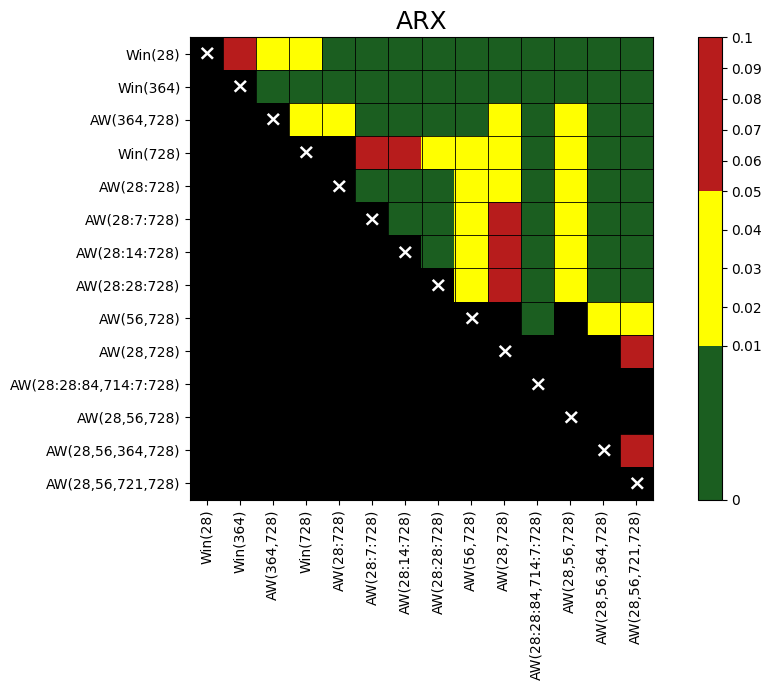

In [ ]:
# Diebold-Mariano p-values
labels = list(table_rows)
n = len(labels)

P = np.full((n, n), np.nan, dtype=float)
for j, yname in enumerate(labels):
    y = daily_losses_df[yname].to_numpy()
    for i, xname in enumerate(labels):
        if i == j:
            continue
        x = daily_losses_df[xname].to_numpy()

        d = (y - x)
        d = d[~np.isnan(d)]
        if d.size < 5:
            continue

        mean_d = d.mean()
        std_d = d.std(ddof=1)
        if std_d == 0:
            P[j, i] = 0.0 if mean_d > 0 else 1.0
        else:
            tstat = mean_d / (std_d / np.sqrt(d.size))
            P[j, i] = float(1 - stats.t.cdf(tstat, df=d.size - 1))

# Mask lower triangle + diagonal for plotting
P_plot = P.copy()
P_plot[np.tril(np.ones_like(P_plot, dtype=bool))] = np.nan

# Threshold coloring
bounds = [0.0, 0.01, 0.05, 0.10]
colors = ["#1b5e20", "#ffff00", "#b71c1c"]  # dark green, yellow, red
cmap = mcolors.ListedColormap(colors)
cmap.set_bad("black")
norm = mcolors.BoundaryNorm(bounds, cmap.N)

P_cat = np.where(P_plot >= 0.10, np.nan, P_plot)  # >=0.10 black

fig, ax = plt.subplots(figsize=(12, 7))
im = ax.imshow(P_cat, cmap=cmap, norm=norm, aspect="equal")
ax.set_title("ARX", fontsize=18)

ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels)

ax.set_xticks(np.arange(-.5, n, 1), minor=True)
ax.set_yticks(np.arange(-.5, n, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=0.6)
ax.tick_params(which="minor", bottom=False, left=False)

for k in range(n):
    ax.text(k, k, "×", ha="center", va="center", color="white", fontsize=16, fontweight="bold")

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ticks = np.round(np.arange(0.0, 0.101, 0.01), 2)
cbar.set_ticks(ticks)
cbar.set_ticklabels([("0" if t == 0 else f"{t:.2f}".rstrip("0").rstrip(".")) for t in ticks])

plt.tight_layout()
plt.show()

## Extention
### Weighted window forecasts (1/MAE on a calibration period)
Weights come from the first chunk of the test set: for each window we compute MAE, take 1/MAE as a weight, and normalize to sum to 1 so better windows matter more.


In [ ]:
# ===== helpers (if not already defined) =====
def mae(y_true, y_pred):
    """Mean Absolute Error that ignores NaNs; returns np.nan if there are no valid pairs."""
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.nan if mask.sum() == 0 else float(np.mean(np.abs(y_true[mask] - y_pred[mask])))


def weighted_ensemble_rolling(preds_mat, y_true, lookback=90):
    """
    Time-varying weighted ensemble of forecasts in price space.

    For each time step t, forecasts from different windows are aggregated using weights proportional to the inverse of their past forecasting error.

        w_T(t) = 1 / MAE_T(t),

    where MAE_T(t) is the mean absolute error of window T computed over the preceding period [t - lookback, t). The weights are then normalize to sum to one.

    For early time steps, when less than 'lookback' observations are available, all available past observations are used (e.g. for t=2 only the first observation is used, for t=3 the first two, etc.), until the full lookback window is reached.
    """

    preds_mat = np.array(preds_mat, dtype=float)   # shape: (k, n)
    y_true = np.array(y_true, dtype=float)         # shape: (n,)
    k, n = preds_mat.shape

    # Absolute errors per window and time
    abs_err = np.abs(preds_mat - y_true[None, :])  # shape: (k, n)
    pred_ens = np.full(n, np.nan, dtype=float)
    weights = np.full((k, n), np.nan, dtype=float)

    for t in range(n):
        # Historical window [a, b) = [max(0, t - lookback), t)
        a = max(0, t - lookback)
        b = t

        if b <= a:
            # No history available (t == 0) -> fallback to equal weights
            w = np.ones(k, dtype=float) / k
        else:
            # MAE for each window over the available history
            maes = np.nanmean(abs_err[:, a:b], axis=1) # shape: (k,)
            # Inverse-MAE weights
            w_raw = 1.0 / maes
            # Normalize to sum to one
            w = w_raw / w_raw.sum()

        # Renormalize over available predictions at time t (in case of NaNs)
        p = preds_mat[:, t]
        avail = ~np.isnan(p)
        if avail.sum() == 0:
            # If no forecast is available at time t, skip this time point
            continue

        w_eff = w.copy()
        w_eff[~avail] = 0.0
        if w_eff.sum() == 0:
            # If all weights correspond to missing forecasts, fall back to equal weights over available ones
            w_eff[avail] = 1.0 / avail.sum()
        else:
            w_eff = w_eff / w_eff.sum()

        weights[:, t] = w_eff
        pred_ens[t] = float(np.sum(w_eff * p))

    return pred_ens, weights

In [26]:
def build_aw_df_equal_vs_weighted(set_defs, pred_price_dict, y_true, lookback=90):
    """
    Build a dataframe comparing equal averaging vs rolling 1/MAE weighting
    for all window-set definitions provided.
    """
    rows = []
    for name, Tset in set_defs.items():
        Ts_available = [T for T in Tset if T in pred_price_dict]
        if len(Ts_available) == 0:
            rows.append(
                {
                    "Name": name,
                    "Size": 0,
                    "MAE_equal": np.nan,
                    "MAE_weighted": np.nan,
                    "delta(weighted-equal)": np.nan,
                    "Tset": [],
                }
            )
            continue

        # Matrix of price forecasts for this set
        preds_price_mat = np.vstack([pred_price_dict[T] for T in Ts_available])  # (k, n)

        # Equal-weight ensemble
        pred_equal = np.nanmean(preds_price_mat, axis=0)
        mae_equal = mae(y_true, pred_equal)

        # Weighted (rolling 1/MAE) ensemble
        pred_weighted, _ = weighted_ensemble_rolling(preds_price_mat, y_true, lookback=lookback)
        mae_weighted = mae(y_true, pred_weighted)

        rows.append(
            {
                "Name": name,
                "Size": len(Ts_available),
                "MAE_equal": mae_equal,
                "MAE_weighted": mae_weighted,
                "delta(weighted-equal)": mae_weighted - mae_equal,
                "Tset": Ts_available,
            }
        )

    df = pd.DataFrame(rows)
    # Sort by weighted MAE first, then equal MAE
    df = df.sort_values(["MAE_weighted", "MAE_equal"], ascending=[True, True]).reset_index(drop=True)
    return df


AW_ARX_compare = build_aw_df_equal_vs_weighted(
    set_defs=set_defs_arx,
    pred_price_dict=pred_price_ARX,  
    y_true=y_true,                   
    lookback=90,                     
)

display(AW_ARX_compare)

,Name,Size,MAE_equal,MAE_weighted,delta(weighted-equal),Tset
0,"AW(28,56,721,728)",4,6.479801,6.358248,-0.121553,"[28, 56, 721, 728]"
1,"AW(28,56,364,728)",4,6.501092,6.371867,-0.129224,"[28, 56, 364, 728]"
2,"AW(28,56,728)",3,6.508577,6.373037,-0.135540,"[28, 56, 728]"
3,"AW(28:28:84,714:7:728)",6,6.513939,6.404655,-0.109284,"[28, 56, 84, 714, 721, 728]"
4,"AW(28,728)",2,6.590983,6.446881,-0.144102,"[28, 728]"
5,"AW(56,728)",2,6.637487,6.534793,-0.102694,"[56, 728]"
6,AW(28:28:728),26,6.858084,6.793456,-0.064628,"[28, 56, 84, 112, 140, 168, 196, 224, 252, 280..."
7,AW(28:14:728),51,6.879129,6.816127,-0.063002,"[28, 42, 56, 70, 84, 98, 112, 126, 140, 154, 1..."
8,AW(28:7:728),101,6.891014,6.827844,-0.063171,"[28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98, 1..."
9,AW(28:728),701,6.898324,6.835352,-0.062973,"[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3..."


Plotting comparison for window set: AW(28,56,721,728)
MAE equal   : 6.479801
MAE weighted: 6.358248
Delta       : -0.121553


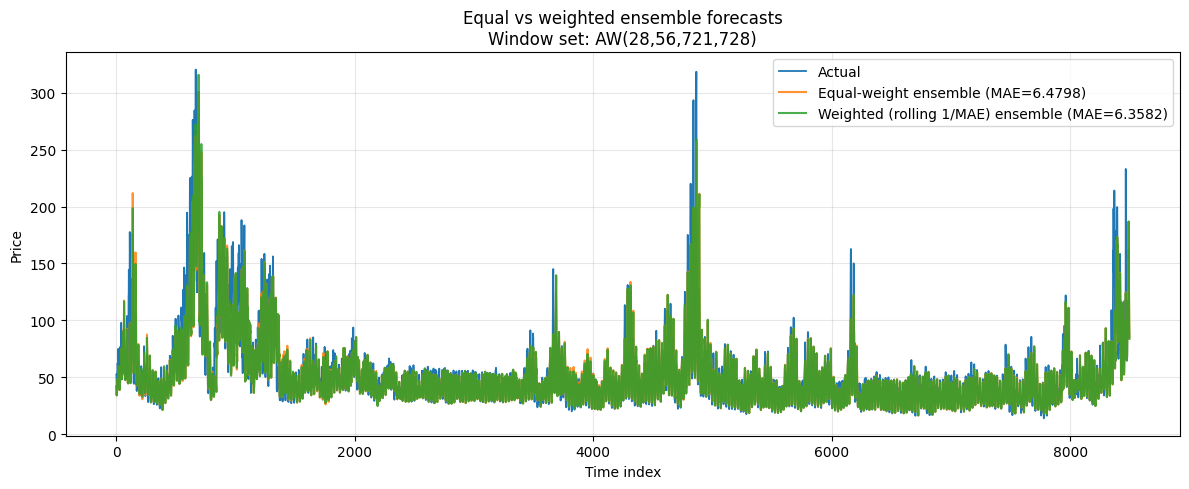

In [28]:
# Choose the best set according to MAE_weighted
best_row = AW_ARX_compare.iloc[0]
set_name = best_row["Name"]
Tset = best_row["Tset"]

print(f"Plotting comparison for window set: {set_name}")
used_Ts = Tset  

# Build matrix of price forecasts for this set
preds_mat = np.vstack([pred_price_ARX[T] for T in used_Ts])

# Equal-weight ensemble
pred_equal = np.nanmean(preds_mat, axis=0)
mae_equal = mae(y_true, pred_equal)

# Weighted ensemble
pred_weighted, W = weighted_ensemble_rolling(preds_mat, y_true, lookback=90)
mae_weighted = mae(y_true, pred_weighted)

print(f"MAE equal   : {mae_equal:.6f}")
print(f"MAE weighted: {mae_weighted:.6f}")
print(f"Delta       : {mae_weighted - mae_equal:.6f}")

# Plot only where all three series are defined
mask = ~np.isnan(y_true) & ~np.isnan(pred_equal) & ~np.isnan(pred_weighted)
y_plot = y_true[mask]
pred_equal_plot = pred_equal[mask]
pred_weighted_plot = pred_weighted[mask]

plt.figure(figsize=(12, 5))
plt.plot(y_plot, label="Actual", linewidth=1.3)
plt.plot(pred_equal_plot, label=f"Equal-weight ensemble (MAE={mae(y_plot, pred_equal_plot):.4f})", alpha=0.85)
plt.plot(pred_weighted_plot, label=f"Weighted (rolling 1/MAE) ensemble (MAE={mae(y_plot, pred_weighted_plot):.4f})", alpha=0.85)

plt.title(f"Equal vs weighted ensemble forecasts\nWindow set: {set_name}")
plt.xlabel("Time index")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
np.max(gefcom.Price), np.min(gefcom.Price)

(np.float64(363.8), np.float64(12.52))